# nuScenes devkit tutorial

Welcome to the nuScenes tutorial. Make sure you have the nuScenes DB schema available.

This demo assumes the database itself is available at `/data/sets/nuscenes`

In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
import matplotlib.pyplot as plt

nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes-v1.0', verbose=True)

Loading NuScenes tables for version v1.0-mini ...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.6 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## A Gentle Introduction to nuScenes

In this part of the tutorial, let us go through a top down introduction of our database. This section is an elaboration of `schema.md`. Our dataset comprises of elemental building blocks that are the following:

1. `scene` - 20 second snippet of a car's journey.
2. `sample` - An annotated snapshot of a scene at a particular timestamp.
3. `sample_data` - Data collected from a particular sensor.
4. `sample_annotation` - An annotated instance of an object within our interest.
5. `instance` - Enumeration of all object instance we observed.
6. `category` - Taxonomy of object categories (e.g. vehicle, human). 
7. `attribute` - Property of an instance that can change while the category remains the same.
8. `visibility` - Fraction of pixels visible in all the images collected from 6 different cameras.. 
9. `sensor` - A specific sensor type.
10. `calibrated sensor` - Definition of a particular sensor as calibrated on a particular vehicle.
11. `ego_pose` - Ego vehicle poses at a particular timestamp.
12. `log` - Log information from which the data was extracted.
13. `map` - Map data that is stored as binary semantic masks from a top-down view.

### 1. `scene`

nuScenes is a large scale database that features annotated samples across ***1000 scenes*** of approximately 20 seconds each. Lets take a look at the scenes that we have in the loaded database.

In [2]:
nusc.list_scenes()arked truck, construction, in

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Bicycle, large truck, wait at intersect... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queenstown, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queenstown, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandvillage, #anns:890
scene-1094, Night, many peds, PMD, ped with bag, ja... [18-11-21 11:47:27]   19s, singapore-hollandvillag

Let us look at a scene metadata

In [3]:
my_scene = nusc.scene[0]
my_scene

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

### 2. `sample`

In-between scenes, we annotate our data for every half a second (2 Hz).

We define `sample` as a ***annotated snapshot of a scene at a given timestamp***. Now, let us look at the first annotated sample in this scene.

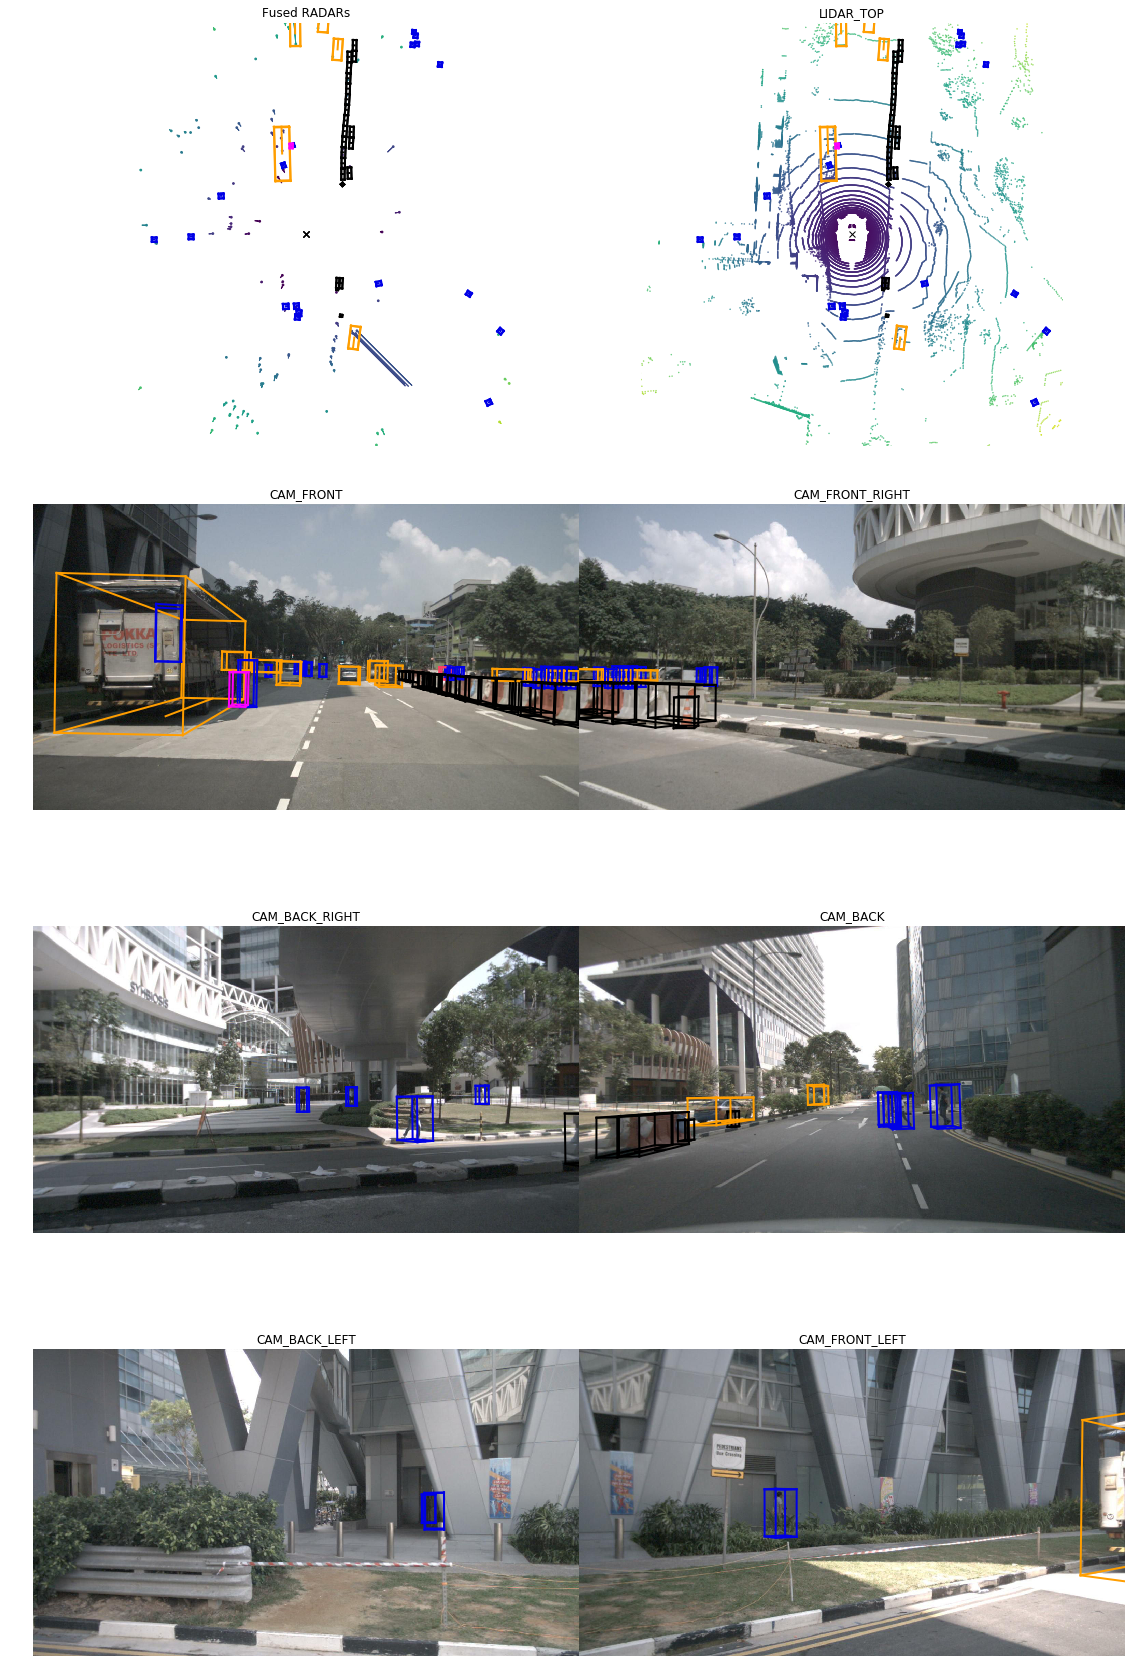

In [4]:
first_sample_token = my_scene['first_sample_token']
nusc.render_sample(first_sample_token)

Lets examine its metadata

In [ ]:
my_sample = nusc.get('sample', first_sample_token)
my_sample

A useful method is  `list_sample()` which lists all related `sample_data` keyframes and `sample_annotation` associated with a sample which we will discuss in detail in the subsequent parts

In [ ]:
nusc.list_sample(my_sample['token'])

### 3. `sample_data`

The nuScenes dataset contains data that is collected from a full sensor suite. Hence, we can see that for each snapshot of a scene, we provide references to a family of data that is collected from these sensors. Notice that we provide a `data` key to access these.

In [ ]:
my_sample['data']

Notice that the keys are referring to the different sensors that forms our sensor suite. Lets take a look at a rendering and the metadata of a `sample_data` that belongs to this `sample` to garner a better understanding.

In [ ]:
which_sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', my_sample['data'][which_sensor])
cam_front_data

In [ ]:
nusc.render_sample_data(cam_front_data['token'])

For sample_data with `is_key_frame=True`, the time-stamps should be very close to the sample it points to. For non key-frames the sample_data points to the sample that follows closest in time.

### 4. `sample_annotation`

`sample_annotation` refers to any ***bounding box defining the position of an object seen in a sample***. All location data is given with respect to the global coordinate system. Lets examine one such example from our `sample` above.

In [ ]:
my_annotation_token = my_sample['anns'][18]
my_annotation_metadata =  nusc.get('sample_annotation', my_annotation_token)
my_annotation_metadata

In [ ]:
nusc.render_annotation(my_annotation_token)

In [ ]:
nusc.get('sample_annotation', my_sample['anns'][18])

### 5. `instance`

An object instance (e.g a particular vehicle, pedestrian). Let us examine an instance metadata

In [ ]:
my_instance = nusc.instance[599]
my_instance

An instance generally spans across different frames in a particular scene. However, we do not track them across different scenes. In this example, we have 24 annotated samples for this instance across a particular scene.

In [ ]:
instance_token = my_instance['token']
nusc.render_instance(instance_token)

An instance record takes note of its first and last annotation token. Let's render them

In [ ]:
import matplotlib.pyplot as plt
print("First annotated sample of this instance:")
nusc.render_annotation(my_instance['first_annotation_token'])
plt.show()
print("Last annotated sample of this instance")
nusc.render_annotation(my_instance['last_annotation_token'])
plt.show()

### 6. `category`

The category table contains a taxonomy of different object categories. We also take note of the subcategories, where they are delineated by a period. Lets take a look at the categories we have in our loaded database

In [ ]:
nusc.list_categories()

A category record contains the name and the description of that particular category.

In [ ]:
nusc.category[9]

You can refer to `instructions.md` for some sample renderings of the different categories that we have.

### 7. `attribute`

An `attribute` is a property of an instance that may change throughout different parts of a scene while the category remains the same. Here are a list of provided attributes.

In [ ]:
nusc.list_attributes()

Lets take a look at an example how an attribute may change over one scene

In [ ]:
my_instance = nusc.instance[27]
first_token = my_instance['first_annotation_token']
last_token = my_instance['last_annotation_token']
nbr_samples = my_instance['nbr_annotations']
current_token = first_token

i = 0
found_change = False
while current_token != last_token:
    current_annot = nusc.get('sample_annotation', current_token)
    current_attribute = nusc.get('attribute', current_annot['attribute_tokens'][0])['name']
    
    if i == 0:
        pass
    elif current_attribute != last_attribute:
        print("Changed from `{}` to `{}` at timestamp {} out of {} annotated timestamps".format(last_attribute, current_attribute, i, nbr_samples))
        found_change = True

    next_token = current_annot['next']
    current_token = next_token
    last_attribute = current_attribute
    i += 1

### 8. `visibility`

`visibility` is defined as the fraction of pixels of a particular annotation that are visible over the 6 camera feeds, binned into 5 bins of 20%.

In [ ]:
nusc.visibility

Lets look at an example `sample_annotation` with 80-100 % visibility

In [ ]:
anntoken = 'a7d0722bce164f88adf03ada491ea0ba'
visibility_token = nusc.get('sample_annotation', anntoken)['visibility_token']

print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
nusc.render_annotation(anntoken)

Lets look at an example `sample_annotation` with 0-40% visibility

In [ ]:
anntoken = 'a8b2f0b7bbe84e4e9520c8de1e4fb98f'
visibility_token = nusc.get('sample_annotation', anntoken)['visibility_token']

print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
nusc.render_annotation(anntoken)

### 9. `sensor`

The nuScenes dataset consists of data collected from our full sensor suite which consists of:
1. 1 x LIDAR, 
2. 5 x RADAR, 
3. 6 x cameras, 

In [ ]:
nusc.sensor

Furthermore, every `sample_data` has a record on which `sensor` the data is collected from (note the "channel" key)

In [ ]:
nusc.sample_data[10] # Note the "channel" key

### 10. `calibrated_sensor`

`calibrated_sensor` consist of definition of a particular sensor (lidar/radar/camera) as calibrated on a particular vehicle. Let us look at an example.

In [ ]:
nusc.calibrated_sensor[0]

Note that the `translation` and the `rotation` parameters are given with respect to the ego vehicle body frame. 

### 11. `ego_pose`

As the name implies, `ego_pose` contains information about the location (encoded in `translation`) and the orientation (encoded in `rotation`) of the ego vehicle body frame.

In [ ]:
nusc.ego_pose[0]

In [ ]:
print("Number of `ego_pose` records in our database: {}".format(len(nusc.ego_pose)))
print("Number of `sample_data` records in our database: {}".format(len(nusc.sample_data)))

Note that the number of `ego_pose` record in our loaded database is the same as the number of `sample_data` record. These two records exhibits a one-to-one correspondence

### 12. `log`

The `log` table contains log information from which the data was extracted

In [ ]:
print("Number of `logs` in our loaded database: {}".format(len(nusc.log)))

In [ ]:
nusc.log[0]

It contains a variety of information such date and location on when the `log` is collected. On top of that, it also gives out information about the `map` mask. One `log` can contain multiple non-overlapping `scenes`.

### 13. `map`

Map data that is stored as binary semantic masks from a top-down view. 

As the maps are updated regularly, there may be multiple versions for the same location. In that case ***the ego_poses of logs with different maps cannot be compared.***

In [ ]:
print("There are {} maps masks in the loaded dataset".format(len(nusc.map)))

In [ ]:
nusc.map[0]

## nuScenes Basics

Lets get a bit technical.

The NuScenes class holds several tables. Each table is a list of records, and each record is a dictionary. For example the first record of the category table is stored at:

In [ ]:
nusc.category[0]

The category table is simple: it just holds fields `name` and `description`. In addition it also has a `token` field, which is a unique record identifier. Since the record is a dictionary, the token can be accessed like so:

In [ ]:
cat_token = nusc.category[0]['token']

If you know the `token` for any record in the DB you can retrieve the record by doing

In [ ]:
nusc.get('category', cat_token)

_As you notice, we have now recovered the same record!_

OK, that was pretty easy. Let's try something harder. Let's look at the `sample_annotation` table.

In [ ]:
nusc.sample_annotation[0]

As you can see this also has a `token` field (they all do). In addition, it has several fields of the format [a-z]* token, e.g. instance_token. These are foreign keys in database speak, meaning they point to another table. 
Using `nusc.get()` we can grab any of these in constant time. For example, let's look at the visibility record.

In [ ]:
nusc.get('visibility', nusc.sample_annotation[0]['visibility_token'])

The visibility records informs of how much of the object was visible when it was annotated.

Let's also grab the `instance_token`

In [ ]:
one_instance = nusc.get('instance', nusc.sample_annotation[0]['instance_token'])
one_instance

This points to the `instance` table. This table enumerate the object _instances_ we have encountered in each 
scene. This way we can connect all annotation of a particular object.

If you look carefully at the README tables, you will see that the sample_annotation table points to the object table, 
but the object table doesn't list all annotations that point to it. 

So how can we recover all sample_annotations for a particular object? There are two ways:

1. `Use nusc.field2token()`. Let's try it:

In [ ]:
ann_tokens = nusc.field2token('sample_annotation', 'instance_token', one_instance['token'])

This returns a list of all sample_annotation records with the `'instance_token'` == `one_instance['token']`. Let's store these in a set for now

In [ ]:
ann_tokens_field2token = set(ann_tokens)

ann_tokens_field2token

The `nusc.field2token()` method is generic and can be used in any similar situation.

2. For certain situation, we provide some reverse indices in the tables themselves. This is one such example. 

The instance record has a field `first_annotation_token` which points to the first annotation in time of this instance. 
Recovering this record is easy.

In [ ]:
ann_record = nusc.get('sample_annotation', one_instance['first_annotation_token'])
ann_record

Now we can traverse all annotations of this instance using the "next" field. Let's try it. 

In [ ]:
ann_tokens_traverse = set()
ann_tokens_traverse.add(ann_record['token'])
while not ann_record['next'] == "":
    ann_record = nusc.get('sample_annotation', ann_record['next'])
    ann_tokens_traverse.add(ann_record['token'])

Finally, let's assert that we recovered the same ann_records as we did using nusc.field2token:

In [ ]:
assert ann_tokens_traverse == ann_tokens_field2token

## Reverse indexing and short-cuts

The nuScenes tables are normalized, meaning that each piece of information is only given once.
For example, there is one `map` record for each `log` record. Looking at the schema you will notice that the `map` table has a `log_token` field, but that the `log` table does not have a corresponding `map_token` field. But there are plenty of situations where you have a `log`, and want to find the corresponding `map`! So what to do? You can always use the `nusc.field2token()` method, but that is slow and inconvenient. We therefore add reverse mappings for some common situations including this one.

Further, there are situations where one needs to go through several tables to get a certain piece of information. 
Consider, for example, the category name (e.g. `human.pedestrian`) of a `sample_annotation`. The `sample_annotation` table doesn't hold this information since the category is an instance level constant. Instead the `sample_annotation` table points to a record in the `instance` table. This, in turn, points to a record in the `category` table, where finally the `name` fields stores the required information.

Since it is quite common to want to know the category name of an annotation, we add a `category_name` field to the `sample_annotation` table during initialization of the NuScenes class.

In this section we list the short-cuts and reverse indices that are added to the `NuScenes` class during initialization. These are all created during in the `NuScenes.__make_reverse_index__()` method.

### Reverse indices
We add two reverse indices by default.
* A `map_token` field is added to the `log` records.
* The `sample` records have shortcuts to all `sample_annotations` for that record as well as `sample_data` key-frames. Confer `nusc.list_sample()` method in the previous section for more details on this.

### Shortcuts

The sample_annotation table has a "category_name" shortcut.

_Using shortcut:_

In [ ]:
catname = nusc.sample_annotation[0]['category_name']

_Not using shortcut:_

In [ ]:
ann_rec = nusc.sample_annotation[0]
inst_rec = nusc.get('instance', ann_rec['instance_token'])
cat_rec = nusc.get('category', inst_rec['category_token'])

In [ ]:
print(catname == cat_rec['name'])

The sample_data table has "channel" and "sensor_modality" shortcuts:

In [ ]:
# Shortcut
channel = nusc.sample_data[0]['channel']


sd_rec = nusc.sample_data[0]
cs_record = nusc.get('calibrated_sensor', sd_rec['calibrated_sensor_token'])
sensor_record = nusc.get('sensor', cs_record['sensor_token'])
print(channel == sensor_record['channel'])

Notice how for both cases w

## Data Visualizations

We provide a set of list and rendering methods. These are meant both as convenience methods during development and as tutorials for building your own. They are implemented in the NuScenesExplorer class, with shortcuts through the NuScenes class itself.

### List methods
There are three list methods availble to look at certain aspects of the loaded DB.

`list_categories()` lists all categories, counts and statistics of width/length/height in meters and aspect ratio.

In [ ]:
nusc.list_categories()

`list_attributes()` lists all attributes and counts.

In [ ]:
nusc.list_attributes()

`list_scenes()` lists all scenes in the loaded DB.

In [ ]:
nusc.list_scenes()

### Render

First, let's plot a lidar point cloud in an image. Lidar allows us to accurate map the surroundings in 3D.

In [ ]:
my_sample = nusc.sample[10]
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP')

Second, let's plot the radar point cloud for the same image. Radar is less dense than lidar, but has a much larger range.

In [ ]:
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='RADAR_FRONT')

We can also plot all annotations across all sample data for that sample. Note how for radar we also plot the velocity vectors of moving objects. Some velocity vectors are outliers, which can be filtered using the settings in RadarPointCloud.from_file()

In [ ]:
my_sample = nusc.sample[20]
nusc.render_sample(my_sample['token'])

Or if we only want to render a particular sensor, we can specify that.

In [ ]:
nusc.render_sample_data(my_sample['data']['CAM_FRONT'])

Additionally we can aggregate the point clouds from multiple sweeps to get a denser point cloud.

In [ ]:
nusc.render_sample_data(my_sample['data']['LIDAR_TOP'], nsweeps=5)
nusc.render_sample_data(my_sample['data']['RADAR_FRONT_RIGHT'], nsweeps=5)

We can even render a specific annotation.

In [ ]:
nusc.render_annotation(my_sample['anns'][22])

Finally, we can render a full scene as a video. There are two options here:
1. nusc.render_scene_channel() renders the video for a particular channel. (HIT ESC to exit)
2. nusc.render_scene() renders the video for all camera channels.

NOTE: These methods use OpenCV for rendering, which doesn't always play nice with IPython Notebooks. If you experience any issues please run these lines from the command line. 

Let's grab scene 0043, it is nice and dense.

In [ ]:
my_scene_token = nusc.field2token('scene', 'name', 'scene-0061')[0]
nusc.render_scene_channel(my_scene_token, 'CAM_FRONT')

There is also a method nusc.render_scene() which renders the video for all camera channels. 
This requires a high-res monitor, and is also best run outside this notebook.

In [ ]:
nusc.render_scene(my_scene_token)

Finally, let us visualize all scenes on the map for a particular location.

In [ ]:
nusc.render_egoposes_on_map(log_location='singapore-onenorth')